# 인공지능과 가위바위보 

### 라이브러리 버전 확인

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.10.0
1.23.5


## Step 1. 데이터 불러오기 및 Resize


In [2]:
# 필요한 모듈 import
from PIL import Image
import glob
import os

In [3]:
# 224x224사이즈에서 28x28사이즈로 변환 함수 만들기
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")
    
    print(len(images), " images to be resized")
    
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
        
    print(len(images), " images resized.")

In [4]:
# 가위 이미지 resize하기
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor_sy"
resize_images(image_dir_path)

# 바위 이미지 resize하기
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock_sy"
resize_images(image_dir_path)

# 보 이미지 resize하기
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper_sy"
resize_images(image_dir_path)

100  images to be resized
100  images resized.
100  images to be resized
100  images resized.
100  images to be resized
100  images resized.


/var/folders/4q/5nms447x5r73lpjnv48256k80000gn/T/ipykernel_40832/3900434163.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  new_img=old_img.resize(target_size,Image.ANTIALIAS)


In [5]:
# 가위, 바위, 보 데이터를 읽을 수 있는 load_data() 함수 만들기
def load_data(img_path, number_of_data=300):
    img_size=28
    color=3 # 컬러는 3, 흑백은 1
    # 가위:0, 바위:1, 보:2 데이터를 담을 행렬 영역 생성(곱셈 형태)
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)
    
    idx=0
    for file in glob.iglob(img_path+'/scissor_sy/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img # 데이터 영역에 이미지 행렬을 복사(idx번째에 이미지 픽셀값 입력)
        labels[idx]=0 # 가위를 0으로 라벨링
        idx=idx+1
        
    for file in glob.iglob(img_path+'/rock_sy/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=1 # 바위를 1로 라벨링
        idx=idx+1
        
    for file in glob.iglob(img_path+'/paper_sy/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=2 # 보를 2로 라벨링
        idx=idx+1
        
        print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
        return imgs, labels
    
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0 # 입력은 0~1 사이 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 201 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


라벨: 0


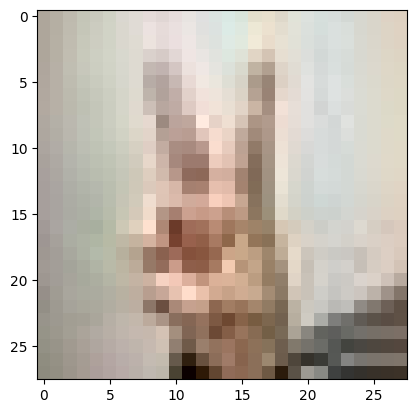

In [6]:
# 이미지 불러오기
import matplotlib.pyplot as plt

plt.imshow(x_train[53])
print('라벨:', y_train[53])

In [7]:
# 학습데이터와 검증데이터 분리
from sklearn.model_selection import train_test_split

x_train_norm, x_valid, y_train, y_valid = train_test_split(x_train_norm, y_train, test_size=0.1, shuffle=False, random_state=20)

print("x_train_norm shape: {}".format(x_train_norm.shape))
print("y_train shape: {}".format(y_train.shape))

x_train_norm shape: (270, 28, 28, 3)
y_train shape: (270,)


- 검증데이터를 만들기 위해 train set에서 9:1로 분리시켰고, 앞 뒤 순서대로 분리해 주었다.

## Step 2. 딥러닝 네트워크 설계하기


In [8]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 32)                2

## Step 3. 딥러닝 네트워크 학습

In [9]:
# x_train 학습 데이터와 검증 데이터 딥러닝 네트워크 학습
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

hist = model.fit(x_train_norm, y_train, epochs=10, validation_data=(x_valid, y_valid))

Epoch 1/10
1/9 [==>...........................] - ETA: 1s - loss: 1.2124 - accuracy: 0.1875

2022-11-27 22:49:13.433963: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


9/9 [==============================] - 0s 14ms/step - loss: 0.9047 - accuracy: 0.7556 - val_loss: 1.0389 - val_accuracy: 1.0000
Epoch 2/10
9/9 [==============================] - 0s 5ms/step - loss: 0.7442 - accuracy: 0.7741 - val_loss: 0.9099 - val_accuracy: 1.0000
Epoch 3/10
9/9 [==============================] - 0s 5ms/step - loss: 0.6629 - accuracy: 0.7556 - val_loss: 0.6830 - val_accuracy: 1.0000
Epoch 4/10
9/9 [==============================] - 0s 5ms/step - loss: 0.5254 - accuracy: 0.9889 - val_loss: 0.3909 - val_accuracy: 1.0000
Epoch 5/10
9/9 [==============================] - 0s 5ms/step - loss: 0.3651 - accuracy: 0.9963 - val_loss: 0.1380 - val_accuracy: 1.0000
Epoch 6/10
9/9 [==============================] - 0s 5ms/step - loss: 0.2372 - accuracy: 0.9963 - val_loss: 0.0287 - val_accuracy: 1.0000
Epoch 7/10
9/9 [==============================] - 0s 5ms/step - loss: 0.1494 - accuracy: 0.9963 - val_loss: 0.0078 - val_accuracy: 1.0000
Epoch 8/10
9/9 [============================

- 300개의 데이터를 또 9:1로 분리시켜 270개의 훈련데이터와 30개의 검증데이터로 학습시키고 loss와 accuracy를 확인했는데 검증데이터의 accuracy가 1.0000이 나와버린 경우도 있고, accuracy가 1.0000이 되었다가 그보다 낮아졌다가 다시 올라가는 경우도 있다. 데이터의 양이 너무 적어서 결과가 이상해진 거 같다.

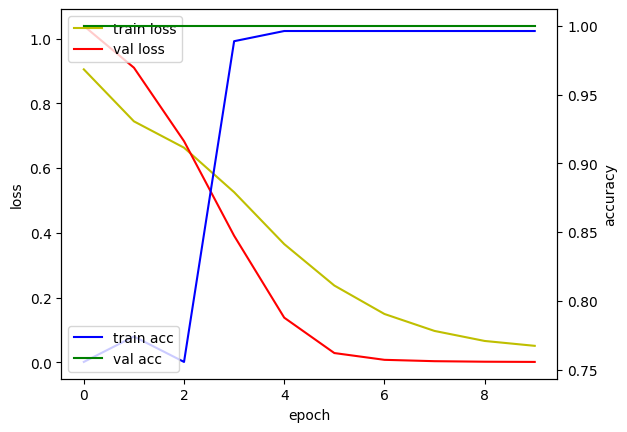

In [10]:
# 학습결과 시각화
import matplotlib.pyplot as plt
%matplotlib inline

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label = 'val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label = 'train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label = 'val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

- 그래프로 봤을 때는 검증데이터의 accuracy가 1이 되는 것을 봐서 검증데이터의 역할을 못하는 것 같다. 그리고 훈련데이터와 검증데이터의 loss가 너무 많이 차이나는 거 같다. 

## Step 4. 성능 확인하기

In [11]:
# x_test, y_test 테스트용 데이터 만들기
def load_test_data(img_path, number_of_data=300):
    img_size=28
    color=3 # 컬러는 3, 흑백은 1
    # 가위:0, 바위:1, 보:2 데이터를 담을 행렬 영역 생성(곱셈 형태)
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)
    
    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img # 데이터 영역에 이미지 행렬을 복사(idx번째에 이미지 픽셀값 입력)
        labels[idx]=0 # 가위를 0으로 라벨링
        idx=idx+1
        
    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=1 # 바위를 1로 라벨링
        idx=idx+1
        
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=2 # 보를 2로 라벨링
        idx=idx+1
        
        print("테스트 데이터(x_test)의 이미지 개수는", idx,"입니다.")
        return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test)=load_test_data(image_dir_path)
x_test_norm = x_test/255.0 # 입력은 0~1 사이 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

테스트 데이터(x_test)의 이미지 개수는 201 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


In [12]:
# test_accurary 측정
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2) # 모델 시험
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 2.1259 - accuracy: 0.6633 - 26ms/epoch - 3ms/step
test_loss: 2.125948429107666
test_accuracy: 0.6633333563804626


- 학습데이터에서는 accuracy가 0.9963이 나온 반면, 테스트데이터에서는 accuracy가 0.6633으로 많이 낮아졌다.  
학습한 후 test를 할 때마다 test accuracy가 변동이 생긴다고 알고 있는데 몇 번을 돌려봐도 항상 일정하게 결과가 나온다. 이미지 증강을 하지 않았음에도 accuracy가 꽤 높게 나온 것도 이상하다. 뭔가 잘못된 거 같다. 전체적으로도 학습데이터와 검증데이터의 양이 적었고 테스트데이터에 비해 학습데이터가 적었기 때문에 발생한 문제인 거 같다.
- 훈련데이터와 검증데이터의 loss가 많이 차이나는 것을 봤을 때에도 확실히 문제가 있는 거 같다.
- 내가 준비한 가위바위보 데이터셋은 하얀 배경에 손만 찍었기 때문에 더 학습이 잘 되었을 수도 있지만 데이터 양이 적었던 것을 고려해 다른 분들의 가위바위보 데이터셋을 받아 총 7372개의 데이터를 가지고 훈련데이터와 검증데이터를 9:1로 나눈 후 학습하고 accuracy를 측정해본 뒤, 같은 300개의 테스트데이터로 다시 accuracy를 측정해보기로 했다.

--------

## Step 1. 데이터 불러오기 및 Resize

In [12]:
# 필요한 모듈 import
import tensorflow as tf
import numpy as np

from PIL import Image
import glob
import os

In [13]:
# 224x224사이즈에서 28x28사이즈로 변환 함수 만들기
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")
    
    print(len(images), " images to be resized")
    
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
        
    print(len(images), " images resized.")

In [14]:
# 가위 이미지 resize하기
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor"
resize_images(image_dir_path)

# 바위 이미지 resize하기
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"
resize_images(image_dir_path)

# 보 이미지 resize하기
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper"
resize_images(image_dir_path)

2467  images to be resized


/var/folders/4q/5nms447x5r73lpjnv48256k80000gn/T/ipykernel_40914/3900434163.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  new_img=old_img.resize(target_size,Image.ANTIALIAS)


2467  images resized.
2504  images to be resized
2504  images resized.
2401  images to be resized
2401  images resized.


In [22]:
# 가위, 바위, 보 데이터를 읽을 수 있는 load_data() 함수 만들기
def load_data(img_path, number_of_data=7372):
    img_size=28
    color=3 # 컬러는 3, 흑백은 1
    # 가위:0, 바위:1, 보:2 데이터를 담을 행렬 영역 생성(곱셈 형태)
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)
    
    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img # 데이터 영역에 이미지 행렬을 복사(idx번째에 이미지 픽셀값 입력)
        labels[idx]=0 # 가위를 0으로 라벨링
        idx=idx+1
        
    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=1 # 바위를 1로 라벨링
        idx=idx+1
        
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=2 # 보를 2로 라벨링
        idx=idx+1
        
        print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
        return imgs, labels
    
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 4972 입니다.
x_train shape: (7372, 28, 28, 3)
y_train shape: (7372,)


라벨: 0


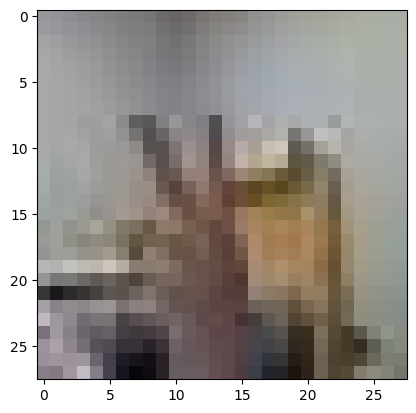

In [23]:
# 이미지 불러오기
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(x_train[960])
print('라벨:', y_train[960])

In [24]:
# 학습데이터와 검증데이터 분리
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, shuffle=False, random_state=20)
# 학습데이터와 검증데이터를 9:1로 분리
# 섞지 않고 9:1로 분리

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

x_train shape: (6634, 28, 28, 3)
y_train shape: (6634,)


In [25]:
# 입력은 0~1 사이 값으로 정규화
x_train_norm = x_train/255.0
x_valid_norm = x_valid/255.0

## Step 2. 딥러닝 네트워크 설계하기

In [31]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        9280      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1600)              0         
                                                                 
 dense_6 (Dense)             (None, 64)               

## Step 3. 딥러닝 네트워크 학습

In [32]:
# x_train 학습 데이터와 검증 데이터 딥러닝 네트워크 학습
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

hist_2 = model.fit(x_train_norm, y_train, epochs=50, validation_data=(x_valid_norm, y_valid))
# 데이터의 크기가 300개에서 7372개로 커졌으므로 epoch값을 10에서 50으로 늘렸다.

Epoch 1/50
208/208 [==============================] - 1s 5ms/step - loss: 0.5277 - accuracy: 0.6856 - val_loss: 3.4922e-04 - val_accuracy: 1.0000
Epoch 2/50
208/208 [==============================] - 1s 4ms/step - loss: 0.3245 - accuracy: 0.8579 - val_loss: 1.4067e-05 - val_accuracy: 1.0000
Epoch 3/50
208/208 [==============================] - 1s 4ms/step - loss: 0.1972 - accuracy: 0.9212 - val_loss: 2.9607e-04 - val_accuracy: 1.0000
Epoch 4/50
208/208 [==============================] - 1s 4ms/step - loss: 0.1302 - accuracy: 0.9500 - val_loss: 5.6028e-06 - val_accuracy: 1.0000
Epoch 5/50
208/208 [==============================] - 1s 4ms/step - loss: 0.0908 - accuracy: 0.9680 - val_loss: 1.5497e-06 - val_accuracy: 1.0000
Epoch 6/50
208/208 [==============================] - 1s 4ms/step - loss: 0.0630 - accuracy: 0.9804 - val_loss: 5.9605e-07 - val_accuracy: 1.0000
Epoch 7/50
208/208 [==============================] - 1s 4ms/step - loss: 0.0544 - accuracy: 0.9815 - val_loss: 1.6928e-05 -

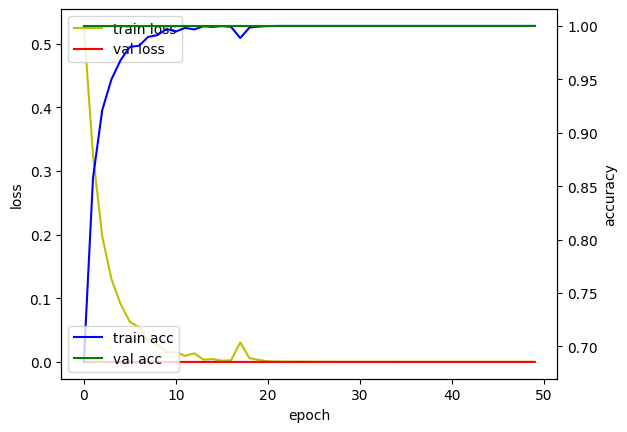

In [33]:
# 학습결과 시각화
import matplotlib.pyplot as plt
%matplotlib inline

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist_2.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist_2.history['val_loss'], 'r', label = 'val loss')

acc_ax.plot(hist_2.history['accuracy'], 'b', label = 'train acc')
acc_ax.plot(hist_2.history['val_accuracy'], 'g', label = 'val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

#### 1. Conv2D 레이어 = 16, 32 / Dense 레이어 = 32

![Conv2D 레이어 = 16, 32](https://user-images.githubusercontent.com/116326867/204144060-882e951d-2895-4427-a000-962035a20f80.jpeg)

- 총 데이터의 개수를 늘려 검증데이터를 30개에서 783개로 늘렸음에도 불구하고 검증데이터가 검증의 역할을 제대로 하지 못하고 있다. 이런 상황이 발생하는 것은 학습데이터와 검증데이터가 겹치기 때문인 거 같다. 분리한다고 했는데 어느 부분이 잘못된 것인지 모르겠다.  
- 위에 내가 준비한 300개의 데이터로만 학습을 시켰던 것이 중복이 되어 문제가 생긴 것일 수도 있기 때문에 중단하고 데이터 개수를 늘린 경우만 다시 학습해보았다. 하지만 데이터 수를 늘린 것만 학습시켜서 본 결과 그렇게 학습시키기 전 그래프와 큰 차이가 없다.    
- 혹시 9:1로 나누는 과정에서 정규화된 데이터를 사용했기 때문에 어떤 문제가 생긴 건 아닐지 생각이 들어서 일단 9:1로 나누어 주고 정규화 과정을 거쳐 학습했으나 그래프의 모양에 크게 변화가 없었다.  
- 검증데이터를 어떻게 해야 더 잘 사용할 수 있을지 더 찾아보고 공부해야겠다. 

#### 2. Conv2D 레이어 = 16, 64 / Dense 레이어 = 64
- 여전히 검증데이터가 역할을 못한다. 그래프로 봤을 때 Conv2D 레이어 = 16, 32 / Dense 레이어 = 32일 때와 Conv2D 레이어 = 16, 64 / Dense 레이어 = 64일 때 큰 차이가 없어 보인다.

## Step 4. 성능 확인하기

In [34]:
# x_test, y_test 테스트용 데이터 만들기
def load_test_data(img_path, number_of_data=300):
    img_size=28
    color=3 # 컬러는 3, 흑백은 1
    # 가위:0, 바위:1, 보:2 데이터를 담을 행렬 영역 생성(곱셈 형태)
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)
    
    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img # 데이터 영역에 이미지 행렬을 복사(idx번째에 이미지 픽셀값 입력)
        labels[idx]=0 # 가위를 0으로 라벨링
        idx=idx+1
        
    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=1 # 바위를 1로 라벨링
        idx=idx+1
        
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=2 # 보를 2로 라벨링
        idx=idx+1
        
        print("테스트 데이터(x_test)의 이미지 개수는", idx,"입니다.")
        return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test)=load_test_data(image_dir_path)
x_test_norm = x_test/255.0 # 입력은 0~1 사이 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

테스트 데이터(x_test)의 이미지 개수는 201 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


In [35]:
# test_accurary 측정
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2) # 모델 시험
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 11.9576 - accuracy: 0.6500 - 32ms/epoch - 3ms/step
test_loss: 11.9575777053833
test_accuracy: 0.6499999761581421


- 300개의 데이터로 학습시킨 후 테스트했을 때에는 accuracy가 0.6633이 나온 것에 비해 7372개의 데이터로 학습시킨 후 테스트했을 때 accuracy가 0.5333으로 더 낮게 나왔다. 중간 과정이 이상한 점도 있었겠지만 단순히 데이터가 많다고 무조건 학습이 잘되는 것은 아니라는 점을 알게 되었다. 
- test accuracy를 높이기 위해 Conv2D 레이어 = 16, 32에서 16,64로 Dense 레이어 = 32에서 64로 바꿔보았다. 신기하게도 test accuracy가 0.5333에서 0.6500으로 급격하게 올라갔다. 물론 train accuracy에 비하면 많이 낮은 수치이지만 레이어를 조정하는 것만으로도 test accuracy가 많이 올라갈 수 있다는 점을 알게 되었다. 근데 test loss값이 11.95가 나온 것을 보면 이것도 잘못된 거 같다는 느낌이 들었다. 이걸 어떻게 해결해야할 지 막막하다.

---------

## 회고
1. 학습과정이 정상적으로 수행되었으며, 학습 결과에 대한 그래프를 시각화를 해 보았는가?  
학습과정이 정상적으로 수행되지 못한 거 같다. lms에 있는 내용을 많이 참고하며 최대한 좋은 결과를 내고 싶었지만 train accuracy가 1이 나오는 건 해결할 수가 없었다. 데이터 중복의 문제일 것이라고 예측은 하지만 어디서 어떻게 중복이 된건지를 알 수가 없어서 정확한 문제를 찾아내지 못했다. 데이터 중복의 문제가 아니더라도 어딘가 문제가 있으니까 이런 결과가 나온 것인데 도저히 찾을 수가 없다. 시간상 일단 마무리 짓지만 다른 사람들에게 조언도 구하고 구글에서 찾아보면서 이 문제는 꼭 해결할 것이다.  
학습과정이 어딘가 잘못되었다는 것은 학습 결과에 대한 그래프를 시각화 해 봤을 때 더욱 느낄 수 있었다. 그래프를 봤을 때, 누가 봐도 검증데이터가 제 역할을 하지 못했다. 어떻게 하면 이 문제들을 해결할 수 있을지 계속해서 고민해봐야겠다.  
2. 오버피팅 극복을 위하여 데이터셋의 다양성, 정규화 등을 2가지 이상 시도해보았는가?  
내가 준비한 300개의 데이터셋과 다른 사람들의 데이터셋을 합쳐서 나온 결과를 비교해보았다. 근데 300개의 데이터셋만 활용했을 때 검증데이터가 확실하게 제 역할을 하지는 못해서 애매하지만 오버피팅이 발생하지는 않았다고 생각한다.  
그리고 0~1 사이 값으로 정규화를 시도해보았다. 그 외에도 오버피팅을 극복하기 위하여 모델의 복잡도를 줄이거나 드롭아웃하는 방법이 있는데 이번에 사용하지는 않았지만 다음에 꼭 도전해보고 싶다.  
3. 분류모델의 test accuracy가 60% 이상 도달하였는가?  
일단 300개의 데이터를 가지고 학습했을 때 Conv2D 레이어와 Dense 레이어를 크게 조정하지 않았음에도 66.33%가 나왔다. 학습과정이 잘못되어서 그런 것일 수도 있고 내가 준비한 데이터가 흰색 배경에 가위, 바위, 보의 형체가 잘 드러나서 학습이 잘된 것일 수도 있는데 뭔가 학습과정에서 문제가 있어 높게 나온 거 같다.  
7372개의 데이터를 가지고 학습했을 때에는 처음에는 53.33%였지만 Conv2D 레이어와 Dense 레이어를 조정하고 난 뒤에 65.00%로 test accuracy가 올라갔다.  
훈련데이터와 검증데이터들의 이미지 증강을 통해 상하좌우를 돌려보기도 하고 채도, 명도 등을 조정해보면서 test accuracy를 더 높일 수 있을 거 같다. 아직 나에게 너무 어려운 단계이지만 학습과정에서 잘못된 부분을 바로 잡은 뒤 이미지 증강도 하면서 test accuracy를 더 높이고 싶은 생각이 들었다.  
4. 프로젝트를 진행하면서 느낀점 : tensorflow가 로컬컴퓨터에 깔리지 않아서 그걸 까는 것부터 총체적 난국인 프로젝트였다. 다행히 많은 분들의 도움으로 tensoflow를 깔 수 있었고, 또 많은 분들의 도움으로 많은 데이터를 모을 수 있었다. 프로젝트를 진행하면서 항상 어렵고 아직 배울 것이 많고 내가 많이 부족하다고 느낀다. 이번 프로젝트 역시도 그런 느낌을 받았지만 더 특별했던 점이 있다. 특히 다른 사람들의 도움을 많이 받았던 프로젝트였기 때문이다. 그 분들이 있었기에 프로젝트를 완성이라도 할 수 있어서 정말 많이 감사했고, 나도 더 열심히 해서 그분들처럼 되고 싶었고, 작은 도움이라도 선뜻 손을 내미는 사람이 되자고 다짐했다.

## Reference
[np.array](https://biology-statistics-programming.tistory.com/112)  
[데이터셋 분리](https://blog.naver.com/PostView.naver?blogId=bya135&logNo=222223666192&redirect=Dlog&widgetTypeCall=true&directAccess=false)  
[훈련데이터와 검증데이터 시각화](https://sevillabk.github.io/1-learning-visualiztion/)  
[오버피팅 극복방법](https://wikidocs.net/61374)  
[이미지증강](https://blog.naver.com/PostView.naver?blogId=beyondlegend&logNo=222339973845&parentCategoryNo=&categoryNo=&viewDate=&isShowPopularPosts=false&from=postView)